In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
!nvidia-smi

Sat Dec 21 12:33:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [5]:

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cuda')

In [9]:
print("Cuda is available?: ", torch.cuda.is_available())
print("Device: ", device)
print("Count of using GPUs: ", torch.cuda.device_count())

Cuda is available?:  True
Device:  cuda
Count of using GPUs:  1


In [10]:
def display_images(image_paths, title, max_images = 4):
  plt.figure(figsize=(12, 3))
  for i, image_path in enumerate(image_paths[:max_images]):
    img = plt.imread(image_path)
    plt.subplot(1, max_images, i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
  plt.show()

In [12]:
"""
import zipfile
zip_file = zipfile.ZipFile('/content/drive/MyDrive/2024_CVProject/ch1-8/ch1-8_dataset.zip')
zip_file.extractall('/content/drive/MyDrive/2024_CVProject/ch1-8/')
"""

"\nimport zipfile\nzip_file = zipfile.ZipFile('/content/drive/MyDrive/2024_CVProject/ch1-8/ch1-8_dataset.zip')\nzip_file.extractall('/content/drive/MyDrive/2024_CVProject/ch1-8/')\n"

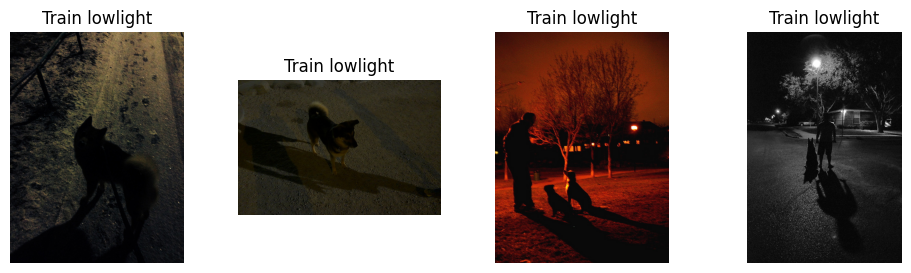

Train lowlight 총 이미지 수: 3686


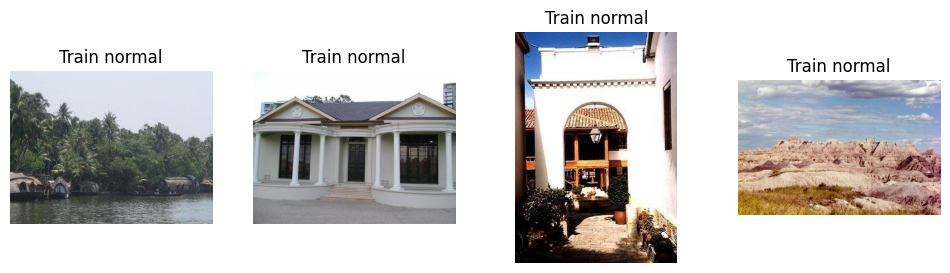

Train normal 총 이미지 수: 3846


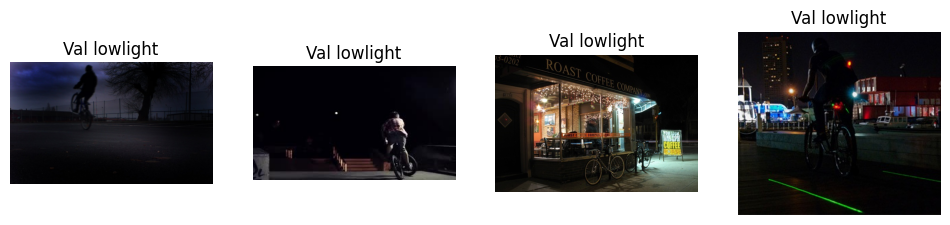

Val lowlight 총 이미지 수: 652


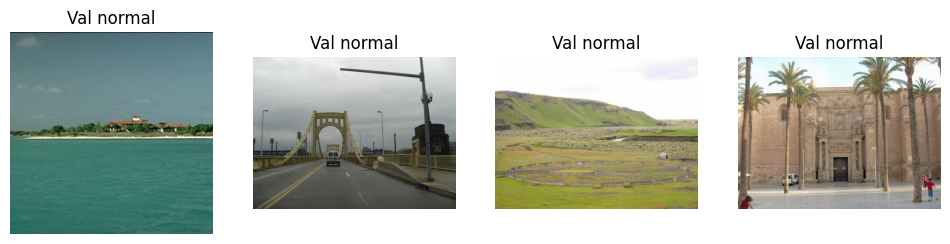

Val normal 총 이미지 수: 689


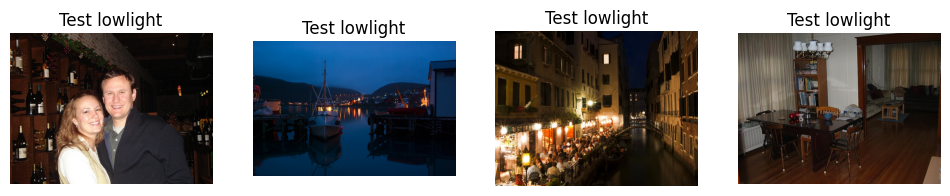

Test lowlight 총 이미지 수: 50


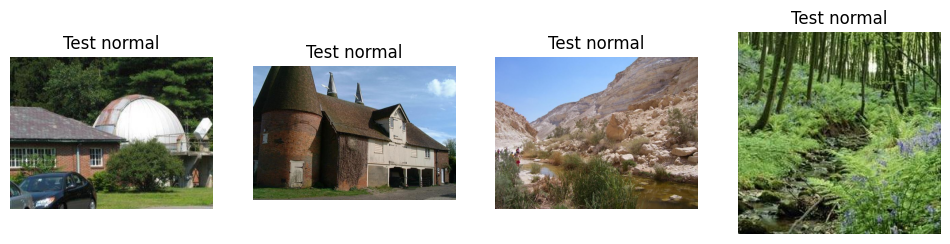

Test normal 총 이미지 수: 50


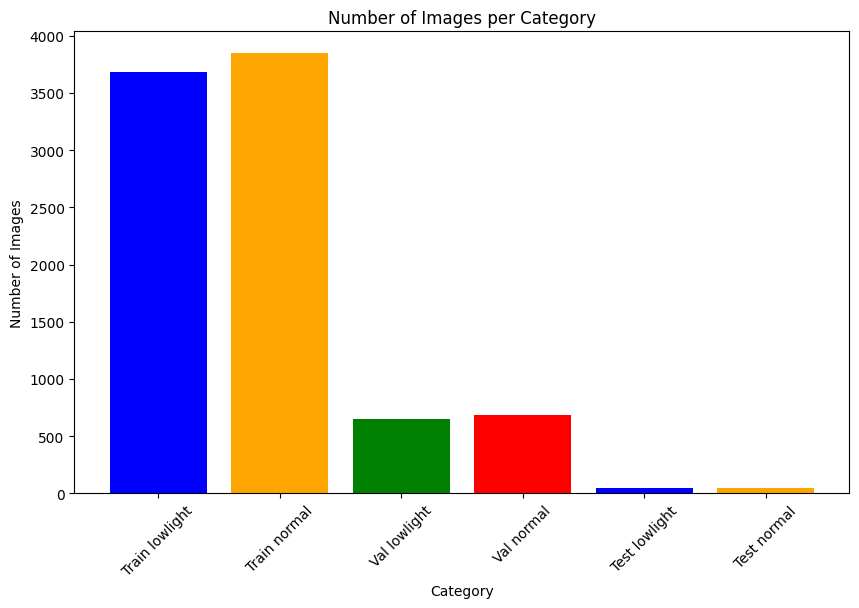

In [13]:
categories = ['Train lowlight', 'Train normal', 'Val lowlight', 'Val normal', 'Test lowlight', 'Test normal']

for category in categories:
    image_paths = glob.glob(f'/content/drive/MyDrive/2024_CVProject/ch1-8/5/{category.lower().replace(" ", "/")}/*')
    display_images(image_paths, category)
    print(f"{category} 총 이미지 수: {len(image_paths)}")

plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'/content/drive/MyDrive/2024_CVProject/ch1-8/5/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [14]:
from imgaug import augmenters as iaa
import imgaug as ia

# imgaug를 사용한 커스텀 데이터셋 정의
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Fliplr(0.5),  # 50% 확률로 좌우 반전
            iaa.Affine(rotate=(-20, 20), mode='symmetric'),  # -20도에서 20도 사이로 회전
        ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

# imgaug를 사용한 커스텀 데이터셋 정의 (light 변화 추가)
class ImgAugTransform_Light:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Fliplr(0.5),  # 50% 확률로 좌우 반전
            iaa.Affine(rotate=(-20, 20), mode='symmetric'),  # -20도에서 20도 사이로 회전
            iaa.Multiply((0.8, 1.2)),  # 밝기 변화, 0.8에서 1.2 범위의 랜덤한 값을 곱함
            iaa.LinearContrast((0.75, 1.5)),  # 대비 조정
            iaa.HistogramEqualization(),
            iaa.CLAHE(),
            iaa.GammaContrast((0.5, 2.0)),  # Gamma 조정, 0.5에서 2.0 사이의 값으로 조정
        ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

# 커스텀 데이터셋 클래스
class CustomDataset(ImageFolder):
    def __init__(self, root, imgaug=None, transform=None):
        super(CustomDataset, self).__init__(root, transform=transform)
        self.imgaug_transform = imgaug  # imgaug 매개변수를 직접 저장

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        # imgaug 증강 적용
        if self.imgaug_transform is not None:
            img = self.imgaug_transform(img)
            # imgaug는 numpy 배열을 반환하므로, PIL Image로 다시 변환
            img = Image.fromarray(img)

        # ToTensor 및 Normalize 적용
        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [15]:
# PyTorch transforms에서 ToTensor 및 Normalize만 적용
from torchvision import transforms
pytorch_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [16]:
from torch.utils.data import SubsetRandomSampler

# 데이터셋의 인덱스를 생성
num_of_train = 7532
num_of_val = 1341
train_indices = list(range(num_of_train))
val_indices = list(range(num_of_val))

# 3000개의 무작위 샘플 선택
np.random.shuffle(train_indices)
train_subset_indices = train_indices[:3000]

np.random.shuffle(val_indices)
val_subset_indices = val_indices[:200]

# 사용자 정의 Sampler 생성
train_sampler = SubsetRandomSampler(train_subset_indices)
val_sampler = SubsetRandomSampler(val_subset_indices)

In [17]:
train_dataset = CustomDataset('/content/drive/MyDrive/2024_CVProject/ch1-8/5/train', imgaug=ImgAugTransform(), transform=pytorch_transforms)
val_dataset = CustomDataset('/content/drive/MyDrive/2024_CVProject/ch1-8/5/val', imgaug=None, transform=pytorch_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, sampler=val_sampler)

In [18]:
# DataLoader에서 샘플을 이미지를 load해 show하는 함수
def imshow(img, size=(20, 20), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean  # 역정규화
    img = np.clip(img, 0, 1)  # 값이 0과 1 사이에 오도록 클리핑
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

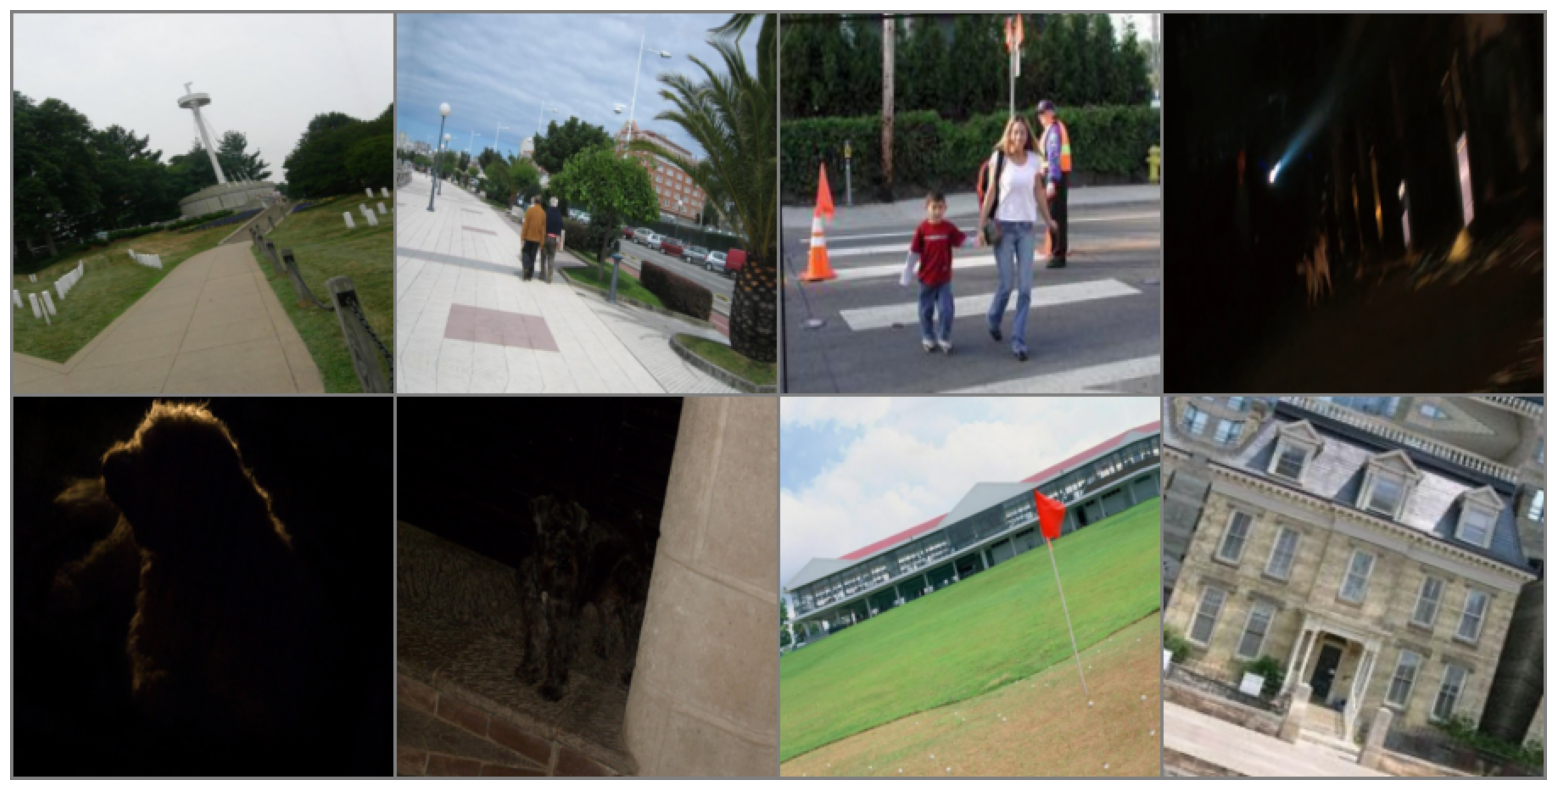

In [19]:
# DataLoader를 이용하여 배치 데이터 가져오기
dataiter = iter(train_loader)
images, _ = next(dataiter)

# 이미지 그리드 생성 및 시각화, nrow를 조정하여 한 줄에 표시되는 이미지의 수 조정
imshow(make_grid(images[:8], nrow=4), size=(20, 10))

In [20]:
# Resnet 모델 로드 및 네트워크 구조 확인
net = models.resnet50(pretrained=True)
net

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
# 모델의 모든 파라미터를 고정
for param in net.parameters():
    param.requires_grad = False

In [22]:
# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
net.fc = nn.Linear(2048, 2)
net.fc.requires_grad = True

In [23]:
net = net.to(device)

In [24]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

In [25]:
def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=30):
    # optimizer설정
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # 학습/검증 손실과 검증 정확도를 저장할 리스트
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 매 에포크마다 평균 학습 손실 계산
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 검증 손실 계산
        val_loss = 0.0
        net.eval()  # 모델을 평가 모드로 설정
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                probabilities = F.softmax(outputs, dim=1) # 로짓 값을 확률로 변환
                _, predicted = torch.max(probabilities, 1) # 확률로 변환한 값 활용하여 Binacy Classificaion 수행
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [26]:
train_losses_default_aug, val_losses_default_aug, val_accuracies_default_aug = train_model('Adam', net, train_loader, val_loader, criterion)

[Adam] Epoch 1, Train Loss: 0.192567, Val Loss: 0.123249, Validation Accuracy: 96.50%
[Adam] Epoch 2, Train Loss: 0.090237, Val Loss: 0.135029, Validation Accuracy: 94.50%
[Adam] Epoch 3, Train Loss: 0.086387, Val Loss: 0.091696, Validation Accuracy: 95.50%
[Adam] Epoch 4, Train Loss: 0.085664, Val Loss: 0.107677, Validation Accuracy: 96.00%
[Adam] Epoch 5, Train Loss: 0.078475, Val Loss: 0.095222, Validation Accuracy: 95.00%
[Adam] Epoch 6, Train Loss: 0.082586, Val Loss: 0.093834, Validation Accuracy: 95.50%
[Adam] Epoch 7, Train Loss: 0.062952, Val Loss: 0.102158, Validation Accuracy: 96.00%
[Adam] Epoch 8, Train Loss: 0.056551, Val Loss: 0.136777, Validation Accuracy: 96.00%
[Adam] Epoch 9, Train Loss: 0.072646, Val Loss: 0.096995, Validation Accuracy: 95.00%
[Adam] Epoch 10, Train Loss: 0.079951, Val Loss: 0.107835, Validation Accuracy: 95.00%
[Adam] Epoch 11, Train Loss: 0.048994, Val Loss: 0.099472, Validation Accuracy: 95.00%
[Adam] Epoch 12, Train Loss: 0.077237, Val Loss: 0.0

In [27]:
# 데이터셋 및 데이터 로더 초기화
train_dataset = CustomDataset('/content/drive/MyDrive/2024_CVProject/ch1-8/5/train', imgaug=ImgAugTransform_Light(), transform=pytorch_transforms)
train_loader = DataLoader(dataset=train_dataset, batch_size=8, sampler=train_sampler)

In [28]:
# DataLoader를 이용하여 배치 데이터 가져오기
dataiter = iter(train_loader)
images, _ = next(dataiter)

# 이미지 그리드 생성 및 시각화, nrow를 조정하여 한 줄에 표시되는 이미지의 수 조정
imshow(make_grid(images[:8], nrow=4), size=(20, 10))

Output hidden; open in https://colab.research.google.com to view.

In [29]:
# 초기화
net = models.resnet50(pretrained=True)
for param in net.parameters():
    param.requires_grad = False
net.fc = nn.Linear(2048, 2)
net.fc.requires_grad = True

net = net.to(device)

In [30]:
train_losses_light_aug, val_losses_light_aug, val_accuracies_light_aug = train_model('Adam', net, train_loader, val_loader, criterion)

[Adam] Epoch 1, Train Loss: 0.250198, Val Loss: 0.120307, Validation Accuracy: 97.00%
[Adam] Epoch 2, Train Loss: 0.205091, Val Loss: 0.310987, Validation Accuracy: 85.50%
[Adam] Epoch 3, Train Loss: 0.179513, Val Loss: 0.305291, Validation Accuracy: 87.50%
[Adam] Epoch 4, Train Loss: 0.220342, Val Loss: 0.125512, Validation Accuracy: 94.50%
[Adam] Epoch 5, Train Loss: 0.184787, Val Loss: 0.129348, Validation Accuracy: 95.50%
[Adam] Epoch 6, Train Loss: 0.172203, Val Loss: 0.151226, Validation Accuracy: 93.00%
[Adam] Epoch 7, Train Loss: 0.193459, Val Loss: 0.132938, Validation Accuracy: 96.00%
[Adam] Epoch 8, Train Loss: 0.193696, Val Loss: 0.321865, Validation Accuracy: 87.50%
[Adam] Epoch 9, Train Loss: 0.196647, Val Loss: 0.575073, Validation Accuracy: 81.00%
[Adam] Epoch 10, Train Loss: 0.224859, Val Loss: 0.131187, Validation Accuracy: 93.00%
[Adam] Epoch 11, Train Loss: 0.159381, Val Loss: 0.167544, Validation Accuracy: 91.50%
[Adam] Epoch 12, Train Loss: 0.168548, Val Loss: 0.1

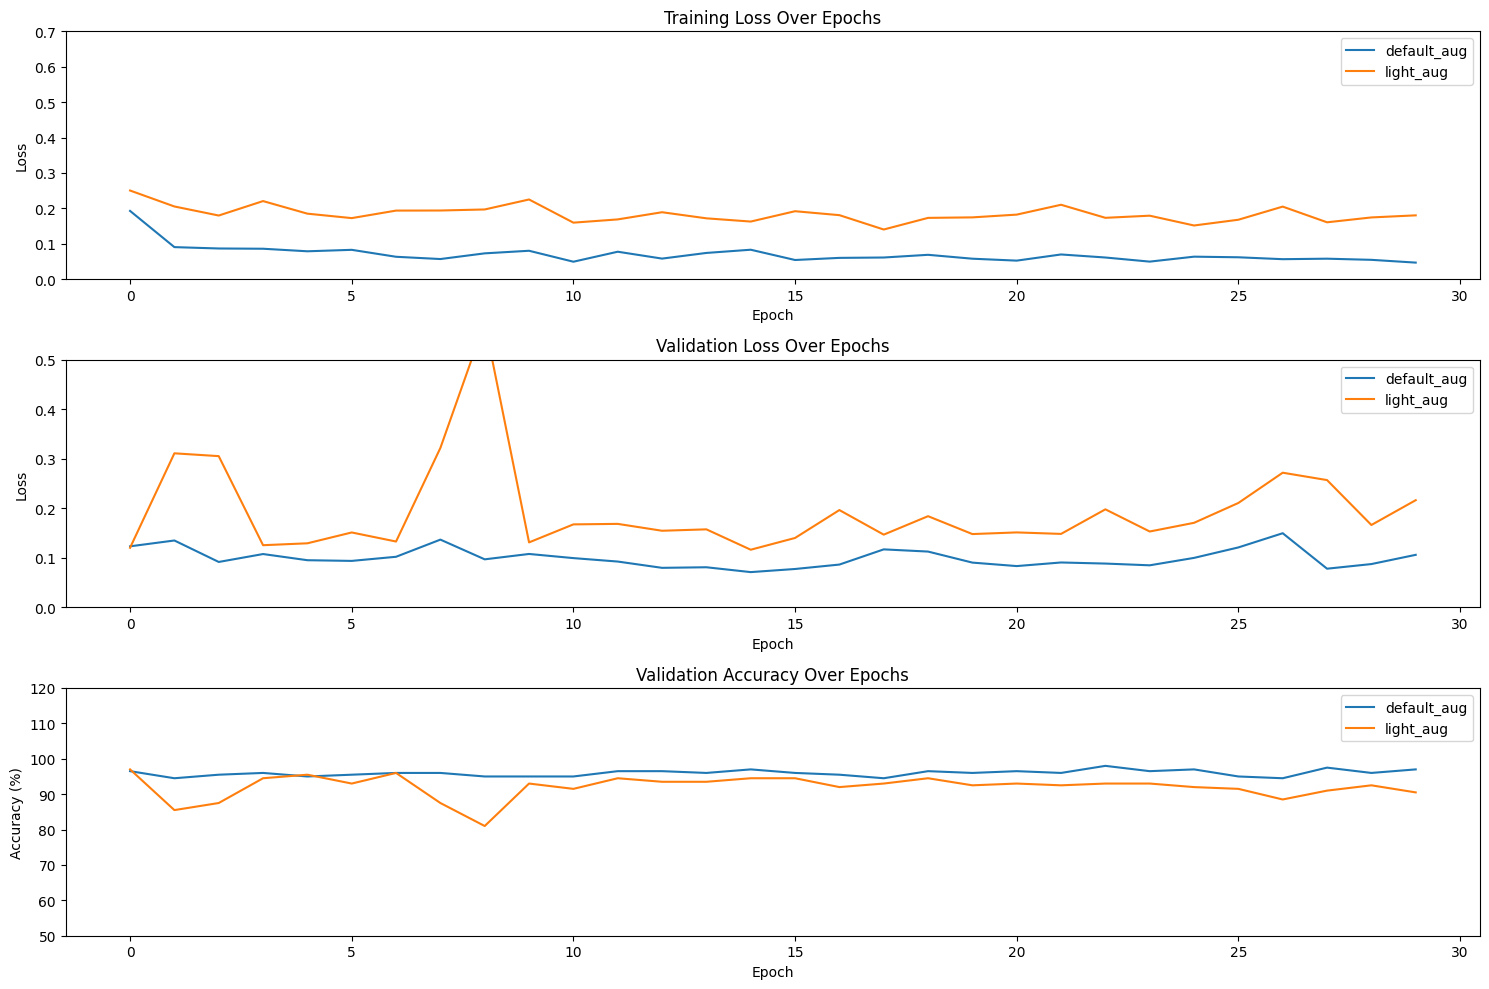

In [31]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_default_aug, label='default_aug')
plt.plot(train_losses_light_aug, label='light_aug')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.ylim(0, 0.7)

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_default_aug, label='default_aug')
plt.plot(val_losses_light_aug, label='light_aug')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.ylim(0, 0.5)

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_default_aug, label='default_aug')
plt.plot(val_accuracies_light_aug, label='light_aug')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.ylim(50, 120)  # y축 범위를 0에서 100까지 설정

plt.tight_layout()
plt.show()

In [32]:
# Image load 및 tensor로 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)  # 이미지를 모델에 맞게 변환하고 배치 차원 추가

In [33]:
# 클래스별 폴더 경로
class_folders = {
    'lowlight': '/content/drive/MyDrive/2024_CVProject/ch1-8/5/test/lowlight',
    'normal': '/content/drive/MyDrive/2024_CVProject/ch1-8/5/test/normal'
}

plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, pytorch_transforms)

        net.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = net(image)
            probabilities = F.softmax(outputs, dim=1) # 로짓 값을 확률로 변환
            _, predicted = torch.max(probabilities, 1) # 확률로 변환한 값 활용하여 Binacy Classificaion 수행
        prediction = 'lowlight' if predicted.item() == 0 else 'normal'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.